### 05/06/2019 To-do list:
1. Calibration curve analog for regression (edited) 
2. Indicate how many points are below/above each parity line
3. Plot multiple cases side by side on the same graph (e.g. test set with 50 pts & 1500 pts)
4. Manipulating dropout

### 06/14/2019 To-do list:
1. If process gets stuck on SDT transform (tqdm) step:
   a. Cache

This document demonstrates the making, training, saving, loading, and usage of a sklearn-compliant CGCNN model.

In [1]:
%load_ext ipycache

/pylon5/ch5fq5p/zulissi/miniconda3/envs/cgcnn/lib/python3.6/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/pylon5/ch5fq5p/zulissi/miniconda3/envs/cgcnn/lib/python3.6/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [2]:
import os
import sys
#Comment/add these
sys.path.insert(0,'../')
sys.path.insert(0,'/home/zulissi/software/adamwr/')

import numpy as np
import cgcnn

import time

#Select which GPU to use if necessary
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


## Load the dataset as mongo docs

In [3]:
import random
import pickle

starttime = time.clock()
#Load a selection of documents
docs = pickle.load(open('/pylon5/ch5fq5p/zulissi/CO_docs.pkl','rb'))
random.seed(42)
random.shuffle(docs)
docs = [doc for doc in docs if -3<doc['energy']<1.0]
docs = docs[:6000]

endtime = time.clock()
print('This operation took', endtime - starttime, 's.')

This operation took 15.040000000000001 s.


## Get the size of the features from the data transformer, to be used in setting up the net model

In [4]:
# %%cache SDT_list.pkl SDT_list
from torch.utils.data import Dataset, DataLoader
import mongo
from cgcnn.data import StructureData, ListDataset, StructureDataTransformer
import numpy as np
import tqdm
from sklearn.preprocessing import StandardScaler

SDT = StructureDataTransformer(atom_init_loc='../atom_init.json',
                              max_num_nbr=12,
                               step=0.2,
                              radius=1,
                              use_tag=False,
                              use_fixed_info=False,
                              use_distance=True)

SDT_out = SDT.transform(docs)

structures = SDT_out[0]

# Settings necessary to build the model (since they are size of vectors as inputs)
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]

import multiprocess as mp
from sklearn.model_selection import ShuffleSplit

SDT_out = SDT.transform(docs)

with mp.Pool(4) as pool:
    SDT_list = list(tqdm.tqdm(pool.imap(lambda x: SDT_out[x],range(len(SDT_out)),chunksize=40),total=len(SDT_out)))


100%|██████████| 6000/6000 [35:06<00:00,  2.85it/s]  


In [5]:
starttime = time.clock()
with open('distance_all_docs.pkl','wb') as fhandle:
    pickle.dump(SDT_list,fhandle)

endtime = time.clock()
print('This step took', endtime - starttime, 's to complete.')

This step took 1.0700000000000003 s to complete.


## CGCNN model with skorch to make it sklearn compliant

In [6]:
from torch.optim import Adam, SGD
from sklearn.model_selection import ShuffleSplit
from skorch.callbacks import Checkpoint, LoadInitState #needs skorch 0.4.0, conda-forge version at 0.3.0 doesn't cut it
from cgcnn.data import collate_pool
from skorch import NeuralNetRegressor
from cgcnn.model import CrystalGraphConvNet
import torch
from cgcnn.data import MergeDataset
import skorch.callbacks.base

cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
else:
    device='cpu'

startime = time.clock()

#Make a checkpoint to save parameters every time there is a new best for validation lost
cp = Checkpoint(monitor='valid_loss_best',fn_prefix='valid_best_')

#Callback to load the checkpoint with the best validation loss at the end of training
class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('valid_best_params.pt')
        
load_best_valid_loss = train_end_load_best_valid_loss()

endtime = time.clock()
print('This step takes', endtime - startime, 's to complete.')

This step takes 0.0 s to complete.


\color{red}{This seems to be a time consuming step.}

## Example converting all the documents up front

In [7]:
starttime = time.clock()
#Make the target list
target_list = np.array([doc['energy'] for doc in docs]).reshape(-1,1)

endtime = time.clock()
print('This step takes', endtime - startime, 's to complete.')

This step takes 0.01999999999999602 s to complete.


## Shuffle and Split

In [8]:
from sklearn.model_selection import train_test_split

starttime = time.clock()
SDT_training, SDT_test, target_training, target_test = train_test_split(SDT_list, target_list, test_size=0.2)

endtime = time.clock()
print('This step takes', endtime - startime, 's to complete.')


This step takes 0.02999999999999403 s to complete.


# Fit the model

In [9]:
from skorch.dataset import CVSplit
from skorch.callbacks.lr_scheduler import WarmRestartLR, LRScheduler

# Since docs is already shuffled, no need to use shufflesplit
train_test_splitter = ShuffleSplit(test_size=0.25, random_state=41)
train_indices, valid_indices = next(train_test_splitter.split(SDT_training))

LR_schedule = LRScheduler('MultiStepLR',milestones=[100],gamma=0.1)
# SDT_training = np.array(SDT_training)

net = NeuralNetRegressor(
    CrystalGraphConvNet,
    module__orig_atom_fea_len = orig_atom_fea_len,
    module__nbr_fea_len = nbr_fea_len,
    # module__dropout = 0.2,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs=188, # 292
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8,
    module__n_h=4,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn = collate_pool,
    iterator_train__shuffle=True,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn = collate_pool,
    device=device,
    criterion=torch.nn.MSELoss,
#   criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    train_split=CVSplit(cv=train_test_splitter), #(SDT_training[train_indices], SDT_training[valid_indices]), # 
    callbacks=[cp, load_best_valid_loss, LR_schedule]
)

In [10]:
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot(SDT_training, SDT_test, target_training, target_test, train_indices, valid_indices, net):
    # train_indices, valid_indices = next(train_test_splitter.split(SDT_training))
    # lentotal = len(SDT_training)
    # train_indices = list(range(round(3/4 * lentotal)))
    # valid_indices = list(range(round(3/4 * lentotal), lentotal))

    training_data = {'actual_value':np.array(target_training.reshape(-1))[train_indices],
                     'predicted_value':net.predict(SDT_training)[train_indices].reshape(-1)}
    test_data = {'actual_value':np.array(target_test).reshape(-1),
                 'predicted_value':net.predict(SDT_test).reshape(-1)}
    validation_data = {'actual_value':np.array(target_training.reshape(-1))[valid_indices],
                       'predicted_value':net.predict(SDT_training)[valid_indices].reshape(-1)}

    df_training = pd.DataFrame(training_data)
    df_validation = pd.DataFrame(validation_data)
    df_test = pd.DataFrame(test_data)
    
    f, ax = plt.subplots(figsize=(8,8))
    ax.scatter(df_training['actual_value'], df_training['predicted_value'], color='orange', 
               marker='o', alpha=0.5, label='train\nMAE=%0.2f, RMSE=%0.2f, R$^2$=%0.2f'\
                %(mean_absolute_error(df_training['actual_value'], df_training['predicted_value']), 
                  np.sqrt(mean_squared_error(df_training['actual_value'], df_training['predicted_value'])),
                  r2_score(df_training['actual_value'], df_training['predicted_value'])))

    ax.scatter(df_validation['actual_value'], df_validation['predicted_value'], color='blue', 
               marker='o', alpha=0.5, label='valid\nMAE=%0.2f, RMSE=%0.2f, R$^2$=%0.2f'\
                %(mean_absolute_error(df_validation['actual_value'], df_validation['predicted_value']), 
                  np.sqrt(mean_squared_error(df_validation['actual_value'], df_validation['predicted_value'])),
                  r2_score(df_validation['actual_value'], df_validation['predicted_value'])))

    ax.scatter(df_test['actual_value'], df_test['predicted_value'], color='green', 
               marker='o', alpha=0.5, label='test\nMAE=%0.2f, RMSE=%0.2f, R$^2$=%0.2f'\
                %(mean_absolute_error(df_test['actual_value'], df_test['predicted_value']), 
                  np.sqrt(mean_squared_error(df_test['actual_value'], df_test['predicted_value'])),
                  r2_score(df_test['actual_value'], df_test['predicted_value'])))


    ax.plot([min(df_training['actual_value']), max(df_training['actual_value'])], 
            [min(df_training['actual_value']), max(df_training['actual_value'])], 'k--')

    # format graph
    ax.tick_params(labelsize=14)
    ax.set_xlabel('DFT E (eV)', fontsize=14)
    ax.set_ylabel('CGCNN predicted E (eV)', fontsize=14)
    ax.set_title('Multi-element ', fontsize=14) 
    ax.legend(fontsize=12)

    plt.show()
    
    return df_training, df_validation, df_test

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer because the following parameters were re-set: .
  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1        0.8125        0.5140     +  11.7025
      2        0.2781        0.3208     +  6.7349
      3        0.2797        0.3108     +  6.7202
      4        0.2429        0.2459     +  6.7182
      5        0.1876        0.2236     +  6.7108
      6        0.1677        0.2063     +  6.7056
      7        0.1777        0.1770     +  6.7025
      8        0.1584        0.1705     +  6.6931
      9        0.1736        0.1771        6.6796
     10        0.1462        0.1778        6.6824
     11        0.1152        0.1864        6.6973
     12        0.1264        0.1815        6.6992
     13        0.1481        0.1612     +  6.7006
     14        0.1

    151        0.0212        0.1054        6.6924
    152        0.0207        0.1032        6.7014
    153        0.0239        0.1081        6.6963
    154        0.0201        0.1106        6.6917
    155        0.0233        0.1059        6.6906
    156        0.0193        0.1079        6.7036
    157        0.0208        0.1034        6.6979
    158        0.0278        0.1080        6.6899
    159        0.0217        0.1116        6.6999
    160        0.0257        0.1101        6.6941
    161        0.0200        0.1100        6.6955
    162        0.0180        0.1118        6.6962
    163        0.0229        0.1057        6.6931
    164        0.0198        0.1075        6.6956
    165        0.0194        0.1148        6.6908
    166        0.0210        0.1101        6.7017
    167        0.0193        0.1090        6.6986
    168        0.0186        0.1034        6.6923
    169        0.0184        0.1173        6.6924
    170        0.0123        0.1029        6.6974


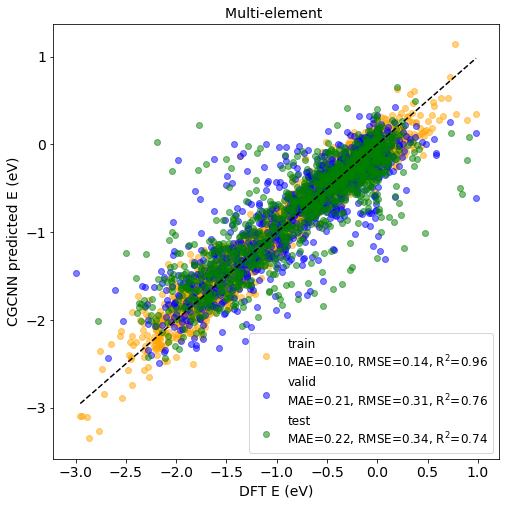

train_indices: [4072 1642 1826 ... 3980  931 1984]
valid_indices: [  21 4608 4215 ... 4557 1892 1334]


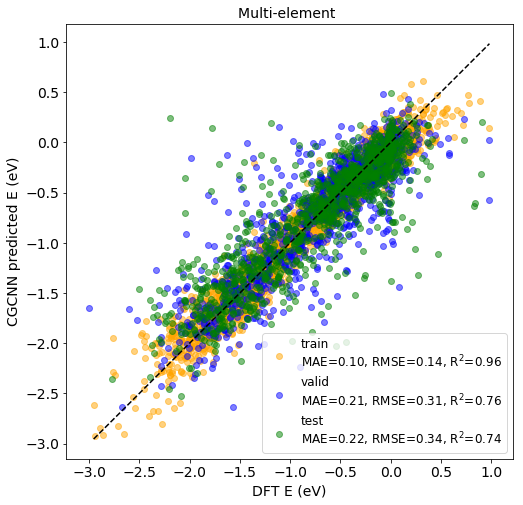

train_indices: [4072 1642 1826 ... 3980  931 1984]
valid_indices: [  21 4608 4215 ... 4557 1892 1334]


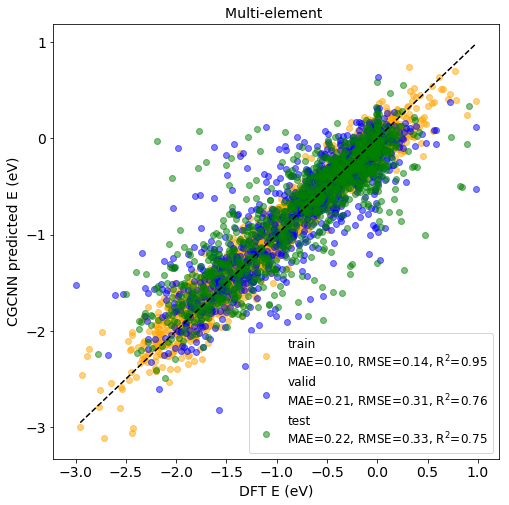

train_indices: [4072 1642 1826 ... 3980  931 1984]
valid_indices: [  21 4608 4215 ... 4557 1892 1334]


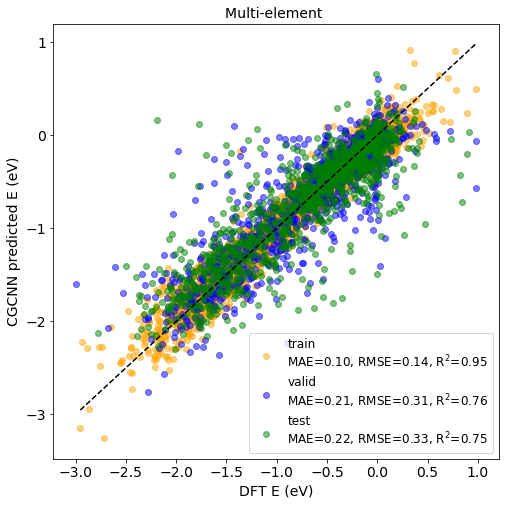

train_indices: [4072 1642 1826 ... 3980  931 1984]
valid_indices: [  21 4608 4215 ... 4557 1892 1334]


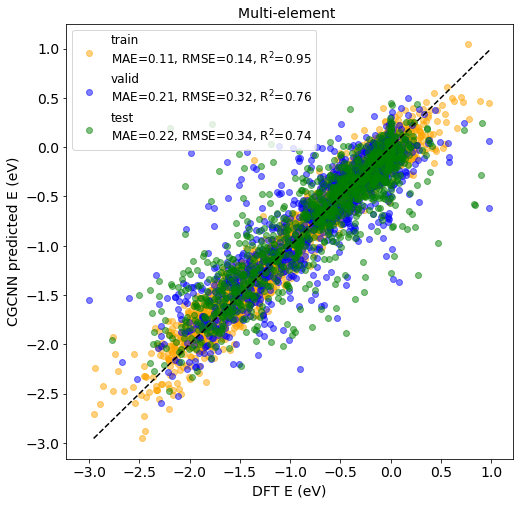

train_indices: [4072 1642 1826 ... 3980  931 1984]
valid_indices: [  21 4608 4215 ... 4557 1892 1334]


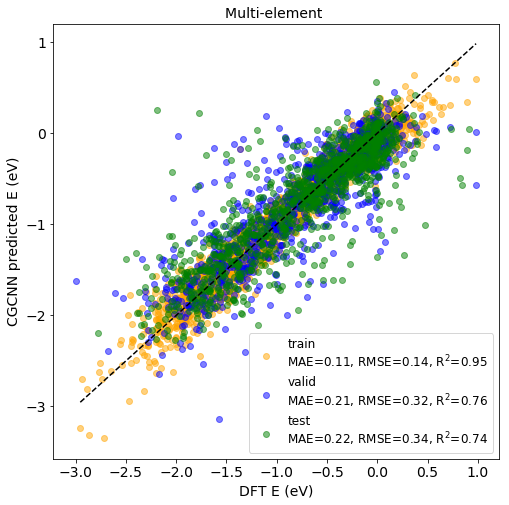

train_indices: [4072 1642 1826 ... 3980  931 1984]
valid_indices: [  21 4608 4215 ... 4557 1892 1334]


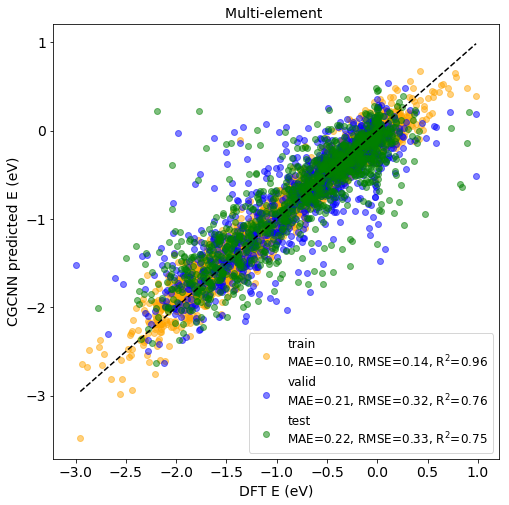

Calculating the same points 7 times takes 1279.1599999999999 s.


In [11]:
TrainingData = []
ValidationData = []
TestData = []

iters = 7

starttime = time.clock()

net.initialize()

# Use sklearn.model_selection.train_test_split with shuffling disabled
train_test_splitter = ShuffleSplit(test_size=0.25, random_state=41)
net.fit(SDT_training, target_training)

for i in range(iters):
    train_test_splitter = ShuffleSplit(test_size=0.25, random_state=41)
    train_indices, valid_indices = next(train_test_splitter.split(SDT_training))
    
    print("train_indices:", train_indices)
    print("valid_indices:", valid_indices)
    
    dftraining, dfvalidation, dftest = plot(SDT_training,
                                            SDT_test,
                                            target_training,
                                            target_test,
                                            train_indices,
                                            valid_indices, net)
    
    TrainingData.append(dftraining)
    ValidationData.append(dfvalidation)
    TestData.append(dftest)
    
TrainingData = pd.concat(TrainingData, axis=1)
ValidationData = pd.concat(ValidationData, axis=1)
TestData = pd.concat(TestData, axis=1)

endtime = time.clock()
print("Calculating the same points {} times takes {} s.".format(iters, endtime-starttime))

In [12]:
"""
# The d20 suffix means a droupout of 20% is applied
TrainingData.to_pickle('TrData_7iters_d20.pkl')
ValidationData.to_pickle('VlData_7iters_d20.pkl')
TestData.to_pickle('TsData_7iters_d20.pkl')
"""


"\n# The d20 suffix means a droupout of 20% is applied\nTrainingData.to_pickle('TrData_7iters_d20.pkl')\nValidationData.to_pickle('VlData_7iters_d20.pkl')\nTestData.to_pickle('TsData_7iters_d20.pkl')\n"

In [13]:
# The d30 suffix means a droupout of 30% is applied
TrainingData.to_pickle('TrData_7iters_d30.pkl')
ValidationData.to_pickle('VlData_7iters_d30.pkl')
TestData.to_pickle('TsData_7iters_d30.pkl')


In [14]:
"""
# The d05 suffix means a droupout of 5% is applied
TrainingData.to_pickle('TrData_7iters_d05.pkl')
ValidationData.to_pickle('VlData_7iters_d05.pkl')
TestData.to_pickle('TsData_7iters_d05.pkl')
"""


"\n# The d05 suffix means a droupout of 5% is applied\nTrainingData.to_pickle('TrData_7iters_d05.pkl')\nValidationData.to_pickle('VlData_7iters_d05.pkl')\nTestData.to_pickle('TsData_7iters_d05.pkl')\n"